In [19]:
#Refer to https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6
#Refer to: https://github.com/JanSchm/CapMarket/blob/master/bot_experiments/IBM_Transformer%2BTimeEmbedding.ipynb
#Train and then validate and test the model

In [20]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.9.1


## Hyperparameters

In [21]:
batch_size = 32
seq_len = 43 # seq_len=43 意思是用43天的数据预测第44天后的趋势
column_len = 6 #6. the number of column
predict_column = 5 #5 (result). which column to be predict, from 0 to column_len-1
d_k = 256 #256
d_v = 256 #256
n_heads = 12 #12
ff_dim = 256 #256
epochs = 3 #20
next_n_day_close = 2 #20
#
stock_id = '300059'
use_checkpoints_id = None #None or else. use other's pre-train model instead of itself(None)
train_from_scratch = True  # True: Train the model, False: Use the pre-train checkpoints
stock_price_path = 'stockData/' + stock_id + '.csv'
preictLen = 86 #Length of test date for predict, -1 means this args is ignore (10% pct is use for test);0 means predict the next date, 1 means predict today and next date... 

In [22]:
#Load data from DB to csv file
from postgres import PostgresDBHandler
postgres = PostgresDBHandler()
length = postgres.get_stock_price_and_save_to_file(stock_id)
#TODO: Should remove the first row of df
if length < 500 and train_from_scratch == 'True':
    print('Length of stock price ' + stock_id + ' is too small (len=' + str(length) + ') for train, pls use other checkpoint for predict')
    sys.exit()

stock price 300059 is saved to stockData/300059.csv


# Moving Average

## Moving Average - Load data again, to apply rolling window

In [23]:
df = pd.read_csv(stock_price_path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])

# Replace 0 to avoid dividing by 0 later on
df['volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('date', inplace=True)


# Apply moving average with a window of 10 days to all columns
#df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].rolling(10).mean() 

# the max close price in next 19 days
df['Max_Close_Price_In_Next_N_Days'] = df['close'].rolling(next_n_day_close).max().shift(-(next_n_day_close-1))
# the close price after 19 days
df['Close_Price_After_N_Days'] = df['close'].shift(-(next_n_day_close-1))

# Close price is less than the max close price after 19 days
df['Max_Close_Diff'] = df['Max_Close_Price_In_Next_N_Days'] - df['close']
df['Close_Diff'] = df['Close_Price_After_N_Days'] - df['close']

# Result should be a predict number, 1 means the price trend is increase 
# (the max close and close within next 10 days is higher then current price)

df['Result'] = 0
#Result is the trend of next next_n_day_close: 1 means increase, 0 means decrease
df.loc[(df['Max_Close_Diff'] > 0) & (df['Close_Diff'] > 0), ['Result']] = 1

# Apply moving average with a window of 10 days to all columns
df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].rolling(10).mean() 

#Result is the next close
#df['Result'] = df['close'].shift(-(next_n_day_close-1))

df.to_csv('stockData/' + stock_id + '_result.csv')

del df['Max_Close_Diff']
del df['Close_Diff']
del df['Close_Price_After_N_Days']
del df['Max_Close_Price_In_Next_N_Days']

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.tail(46)

,date,open,high,low,close,volume,Result
3092,2023-04-27,16.988,17.165,16.654,16.873,2801297.6,1
3093,2023-04-28,16.773,16.995,16.459,16.690,2883371.4,0
3094,2023-05-04,16.590,16.777,16.256,16.476,2798986.3,1
3095,2023-05-05,16.379,16.582,16.055,16.275,2846272.3,1
3096,2023-05-08,16.186,16.424,15.857,16.119,2970449.7,1
3097,2023-05-09,16.036,16.369,15.707,15.981,3444430.1,0
3098,2023-05-10,15.882,16.225,15.602,15.891,3448187.4,0
3099,2023-05-11,15.837,16.184,15.620,15.897,3158705.1,0
3100,2023-05-12,15.837,16.168,15.604,15.852,3120407.4,1
3101,2023-05-15,15.798,16.175,15.577,15.873,3159106.1,0


## Moving Average - Plot daily closing prices and volume

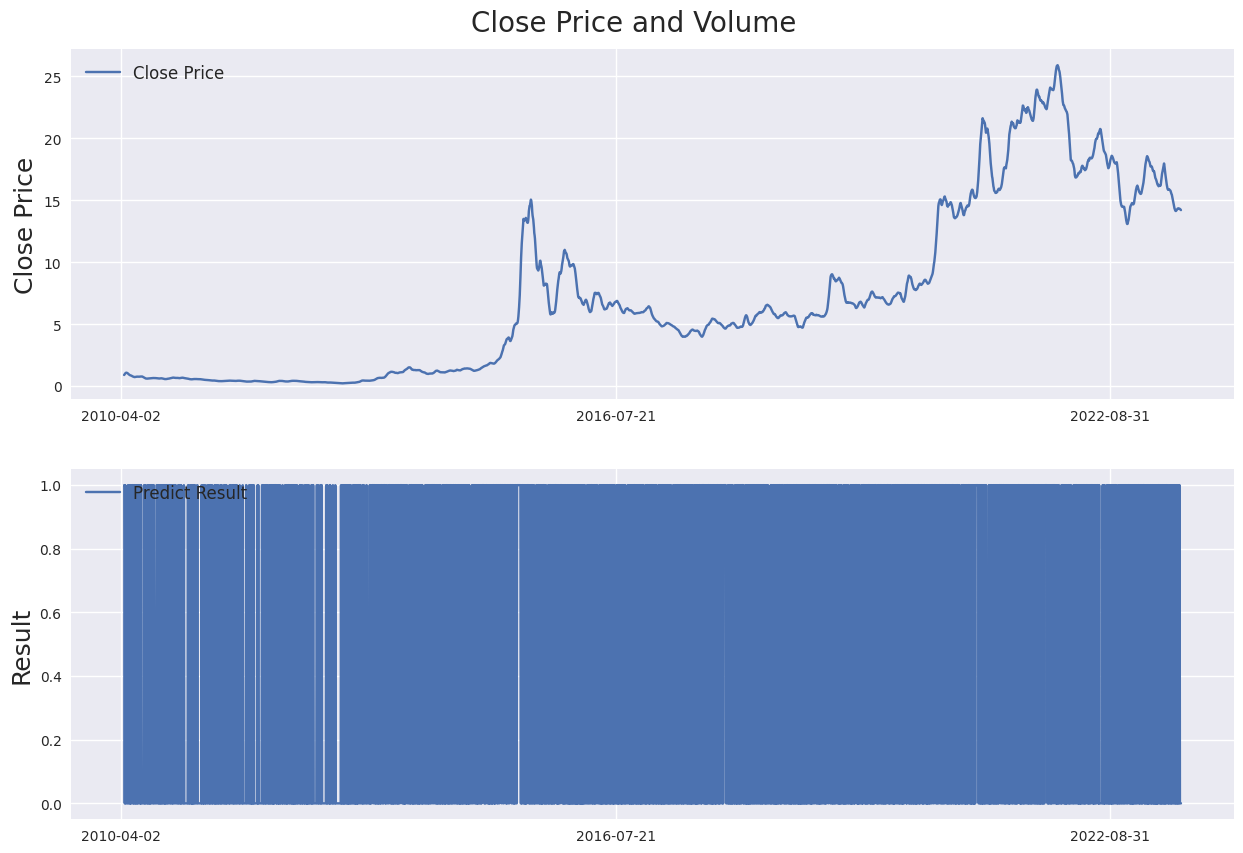

In [24]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['close'], label='Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Result'], label='Predict Result')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['date'].loc[::1464])
ax2.set_ylabel('Result', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)
plt.show()

## Moving Average - Calculate normalized percentage change for all columns

In [25]:
'''Calculate percentage change''' 
df['open'] = df['open'].pct_change() # Create arithmetic returns column
df['high'] = df['high'].pct_change() # Create arithmetic returns column
df['low'] = df['low'].pct_change() # Create arithmetic returns column
df['close'] = df['close'].pct_change() # Create arithmetic returns column
df['volume'] = df['volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#Why min max is based on index < 20 pct? Why Not based on all?
min_return = min(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['open'] = (df['open'] - min_return) / (max_return - min_return)
df['high'] = (df['high'] - min_return) / (max_return - min_return)
df['low'] = (df['low'] - min_return) / (max_return - min_return)
df['close'] = (df['close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''
#Why min max is based on index < 20 pct? Why Not based on all?
min_volume = df[(df.index < last_20pct)]['volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['volume'] = (df['volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Normalize Result column'''

min_result = df[(df.index < last_20pct)]['Result'].min(axis=0)
max_result = df[(df.index < last_20pct)]['Result'].max(axis=0)

# Min-max normalize Result columns (0-1 range)
#It seams if result is either 0 or 1, then it does not need normalize
df['Result'] = (df['Result'] - min_result) / (max_result - min_result)
###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]


if train_from_scratch == False and preictLen != -1:
    #if train_from_scratch is False
    #self.seq_len + self.preictLen + 1: the last +1 is for the prediction date
    df_test = df[-(seq_len + preictLen + 1):]
    df_test_with_date = df[-(seq_len + preictLen + 1):]                                    
else:
    #if train_from_scratch is True, then use the only last 10 pct for predict
    df_test = df[(df.index >= last_10pct)]
    df_test_with_date = df[(df.index >= last_10pct)]        

# Remove date column
df_train.drop(columns=['date'], inplace=True)
df_val.drop(columns=['date'], inplace=True)
df_test.drop(columns=['date'], inplace=True)

#cheat my self?
#df_test['Result']=0

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
test_data_with_date = df_test_with_date.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))
print('df_test_with_date data shape: {}'.format(df_test_with_date.shape))

print(df_train.head(45))
#print(df_test.head())
#print(test_data)
#print(df_test_with_date)

Training data shape: (2503, 6)
Validation data shape: (313, 6)
Test data shape: (312, 6)
df_test_with_date data shape: (312, 7)
        open      high       low     close    volume  Result
10  0.614741  0.639294  0.617904  0.645867  0.142549     1.0
11  0.661391  0.654147  0.650851  0.660787  0.154618     0.0
12  0.648352  0.591905  0.591284  0.545944  0.173755     1.0
13  0.534049  0.554151  0.531294  0.572013  0.180643     0.0
14  0.567189  0.554651  0.527167  0.529630  0.191506     0.0
15  0.524825  0.475511  0.479689  0.426173  0.189801     0.0
16  0.420767  0.390012  0.416604  0.385077  0.177370     0.0
17  0.379390  0.328776  0.349495  0.309912  0.178008     0.0
18  0.297651  0.272593  0.306853  0.309378  0.165138     0.0
19  0.314573  0.299539  0.300118  0.285292  0.169084     0.0
20  0.284361  0.229897  0.237291  0.188785  0.171729     1.0
21  0.180704  0.185740  0.183820  0.171299  0.171521     1.0
22  0.175005  0.204521  0.230555  0.266348  0.163583     0.0
23  0.271526  0.23

## Moving Average - Plot daily changes of close price and volume

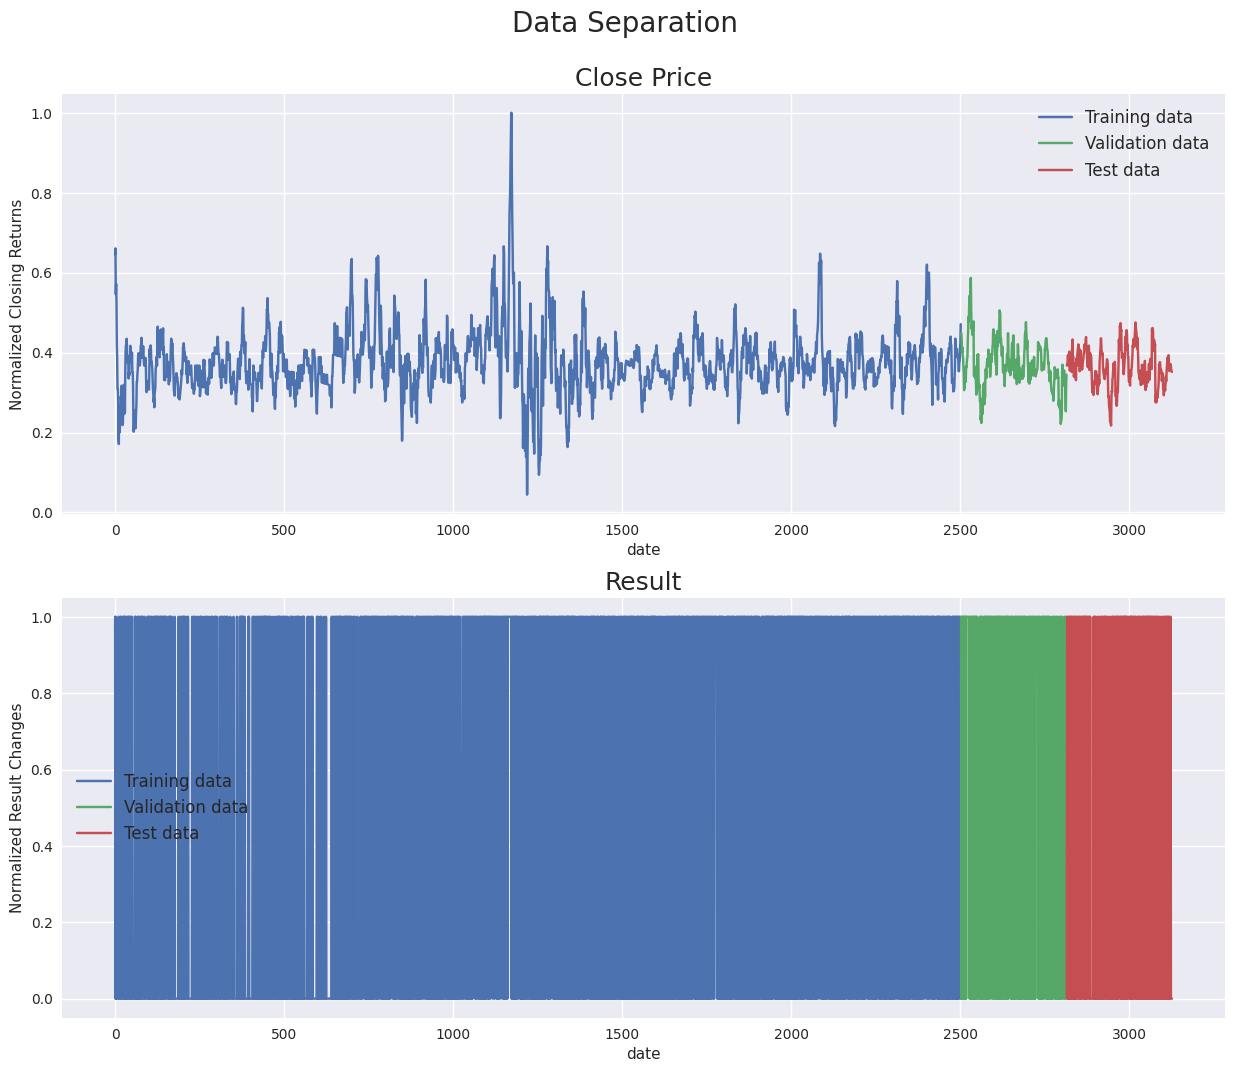

In [26]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['close'], label='Test data')
ax1.set_xlabel('date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Result'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Result'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Result'], label='Test data')
ax2.set_xlabel('date')
ax2.set_ylabel('Normalized Result Changes')
ax2.set_title("Result", fontsize=18)
ax2.legend(loc="best", fontsize=12)
plt.show()

## Moving Average - Create chunks of training, validation, and test data

In [27]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):     ##remove result column for train ,0:5  or ,0:7 for include h1&h2
  X_train.append(train_data[i-seq_len:i,0:6]) # Chunks of training data with a length of 128 df-rows; 0~5 column
  y_train.append(train_data[:, predict_column][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i,0:6])#remove result column for val ,0:5
    y_val.append(val_data[:, predict_column][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
X_test_with_data, X_test_last_43 = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i,0:6])#remove result column for test ,0:5
    X_test_with_data.append(test_data_with_date[i-seq_len:i])
    y_test.append(test_data[:, predict_column][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

X_test_with_data = np.array(X_test_with_data)
X_test_last_43 = X_test[-1:]
X_test_with_date_last_43 = X_test_with_data[-1:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

print(X_train[1])
print(y_train[1])

(2460, 43, 6) (2460,)
(270, 43, 6) (270,)
(269, 43, 6) (269,)
[[0.66139138 0.65414654 0.65085131 0.66078715 0.15461834 0.        ]
 [0.64835199 0.5919045  0.5912837  0.54594361 0.17375464 1.        ]
 [0.53404918 0.55415101 0.53129382 0.57201256 0.18064338 0.        ]
 [0.56718884 0.55465131 0.5271667  0.52962989 0.19150603 0.        ]
 [0.52482493 0.47551149 0.47968922 0.42617263 0.18980061 0.        ]
 [0.42076669 0.39001227 0.4166035  0.38507722 0.17736965 0.        ]
 [0.37939022 0.32877614 0.3494946  0.3099115  0.17800822 0.        ]
 [0.2976506  0.27259282 0.30685273 0.30937845 0.1651383  0.        ]
 [0.314573   0.29953858 0.30011814 0.28529181 0.16908412 0.        ]
 [0.2843607  0.22989685 0.23729095 0.18878501 0.17172873 1.        ]
 [0.18070449 0.1857395  0.18382028 0.17129934 0.17152127 1.        ]
 [0.17500469 0.20452084 0.23055523 0.26634836 0.16358319 0.        ]
 [0.27152617 0.23121532 0.25421517 0.20032365 0.15678507 0.        ]
 [0.1723865  0.19650127 0.2181544  0.2089

## Moving Average - Model

In [28]:
from model.transformer import TransformerEncoder
from model.transformer import Time2Vector
from model.transformer import MultiAttention
from model.transformer import SingleAttention
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, column_len)) #remove result column for train: column_len - 1
  x = time_embedding(in_seq)    
    
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  #out = Dense(1, activation='linear')(x)
  out = Dense(1, activation='sigmoid')(x) #predict 1 or 0

  model = Model(inputs=in_seq, outputs=out)
  #model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])#linear use mse
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', 'mape'])#sigmoid use binary_crossentropy
  return model


model = create_model()
model.summary()

ckp = './checkpoints/Transformer+TimeEmbedding_' + str(seq_len) + '_' + stock_id + '.hdf5'
callback = tf.keras.callbacks.ModelCheckpoint(ckp, 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

if train_from_scratch:
    history = model.fit(X_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        callbacks=[callback],
                        validation_data=(X_val, y_val))  
else:
    if use_checkpoints_id != None:
        ckp = './checkpoints/Transformer+TimeEmbedding_' + str(seq_len) + '_' + use_checkpoints_id + '.hdf5'
        
    model = tf.keras.models.load_model(ckp,
                                       custom_objects={'Time2Vector': Time2Vector, 
                                                       'SingleAttention': SingleAttention,
                                                       'MultiAttention': MultiAttention,
                                                       'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 43, 5)]      0           []                               
                                                                                                  
 time2_vector_1 (Time2Vector)   (None, 43, 2)        172         ['input_2[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 43, 7)        0           ['input_2[0][0]',                
                                                                  'time2_vector_1[0][0]']         
                                                                                                  
 transformer_encoder_3 (Transfo  (None, 43, 7)       99114       ['concatenate_1[0][0]',    

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 43, 5), found shape=(None, 43, 6)


In [ ]:
###############################################################################
'''Display results'''

df2 = pd.read_csv(stock_price_path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])
df2.sort_values('date', inplace=True)
df2_close = df2['close'].values

df2_test_close_price   = df2_close[-len(test_data):]
df2_val_close_price    = df2[(df2.index >= last_20pct) & (df2.index < last_10pct)]['close'].values
df2_train_close_price  = df2[(df2.index < last_20pct)]['close'].values
####

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model " + stock_id, fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
#ax11.plot(train_data[:, 3], label='Result')
ax11.plot(df2_train_close_price, label='Close Price', color='g')
#ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Result')

df2_train_close_price_4_show = df2_train_close_price[-(len(df2_train_close_price)-seq_len):]
states_buy = []
index = 0
for pred in train_pred:
    if pred >= 0.75:
        states_buy.append(df2_train_close_price_4_show[index])
    else:
        states_buy.append(None)
    index += 1    
        
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), states_buy, label='Predict Buy Period', color='r')

ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('date')
ax11.set_ylabel('Result')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
#ax21.plot(val_data[:, 3], label='Result')
ax21.plot(df2_val_close_price, label='Close Price', color='g')
#ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Result')

df2_val_close_price_4_show = df2_val_close_price[-(len(df2_val_close_price)-seq_len):]
states_buy = []
index = 0
for pred in val_pred:
    if pred >= 0.75:
        states_buy.append(df2_val_close_price_4_show[index])
    else:
        states_buy.append(None)
    index += 1    
        
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), states_buy, label='Predict Buy Period', color='r')


ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('date')
ax21.set_ylabel('Result')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
#ax31.plot(test_data[:, 3], label='Result')
ax31.plot(df2_test_close_price, label='Close Price', color='g')
#ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Result')

df2_test_close_price_4_show = df2_test_close_price[-(len(df2_test_close_price)-seq_len):]
states_buy = []
index = 0
for pred in test_pred:
    if pred >= 0.75:
        states_buy.append(df2_test_close_price_4_show[index])
    else:
        states_buy.append(None)
    index += 1    
            
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), states_buy, label='Predict Buy Period', color='r')

#
ax31.set_title("Test Data", fontsize=18)
#ax31.set_xlabel('date')
ax31.set_xticks(range(0, df_test_with_date.shape[0], 1464))
ax31.set_xticklabels(df_test_with_date['date'].loc[::1464])
ax31.set_ylabel('Result')
ax31.legend(loc="best", fontsize=12)
plt.show()

## Moving Average - Model metrics

In [ ]:
'''Display model metrics'''
if train_from_scratch:
    fig = plt.figure(figsize=(15,20))
    st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
    st.set_y(0.92)

    #Plot model loss
    ax1 = fig.add_subplot(311)
    ax1.plot(history.history['loss'], label='Training loss (MSE)')
    ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
    ax1.set_title("Model loss", fontsize=18)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend(loc="best", fontsize=12)

    #Plot MAE
    ax2 = fig.add_subplot(312)
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean average error (MAE)')
    ax2.legend(loc="best", fontsize=12)

    #Plot MAPE
    ax3 = fig.add_subplot(313)
    ax3.plot(history.history['mape'], label='Training MAPE')
    ax3.plot(history.history['val_mape'], label='Validation MAPE')
    ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Mean average percentage error (MAPE)')
    ax3.legend(loc="best", fontsize=12)
    plt.show()

In [ ]:
print(X_test.shape, y_test.shape)
#test_pred = model.predict(X_test)

print('len of test_pred:', len(test_pred))
df_test_with_date=df_test_with_date[-(len(df_test_with_date)-seq_len):]
print('len of df_test_with_date:', len(df_test_with_date))

#print('last 60 of test_pred:',test_pred[-60:])
#print('last 60 of df_test_with_date:',df_test_with_date['date'][-60:])

#for pred in test_pred:
#    print(pred)
#for date in df_test_with_date['date'].values:
#    print(date)

In [ ]:
#Save AI predict to DB
import psycopg2
import numpy

#Establishing the connection
conn = psycopg2.connect(
   database="easystogu", user='postgres', password='postgres', host='192.168.10.200', port= '5432'
)
#Setting auto commit false
conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#First delete then insert
index=0
for date in df_test_with_date['date'].values:
    result=test_pred[index][0]
    print(stock_id, date, result)
    #cursor.execute("delete from AI_TREND_PREDICTION where stockid=%s and date=%s", (stock_id,date))
    #cursor.execute("insert into AI_TREND_PREDICTION (stockid,date,result) values(%s, %s, %s)", (stock_id, date, result))
    index+=1

# Commit your changes in the database
conn.commit()

# Closing the connection
conn.close()